### Load libraries

In [3]:
import os
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special
import torchvision.datasets
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

### Load data

In [4]:
# Load mnist data
root = os.path.expanduser("/var/tmp/scratch")
mnist_train = torchvision.datasets.MNIST(root, train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root, train=False, download=True)

XS_TRAIN, YS_TRAIN = mnist_train.data.numpy(), mnist_train.targets.numpy()
XS_TEST, YS_TEST = mnist_test.data.numpy(), mnist_test.targets.numpy()

XS_TRAIN = XS_TRAIN.reshape(-1, 28 * 28)
XS_TEST = XS_TEST.reshape(-1, 28 * 28)

XS_TRAIN.shape, YS_TRAIN.shape, XS_TEST.shape

((60000, 784), (60000,), (10000, 784))

### Experiment code

In [5]:
def get_min_xent(probs: np.ndarray, labs: np.ndarray) -> float:
    logits = np.log(probs)

    def get_xent(alpha: float) -> float:
        tlogits = logits * alpha
        tprobs = scipy.special.softmax(tlogits, axis=1)
        return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()

    res = scipy.optimize.minimize_scalar(get_xent, bounds=(0.01, 20))
    return res.fun

def run_experiment(
    n_train: int,
    n_classes: int,
    C: float,
    max_iter: int,
    seed: int = 0,
    debug: bool = False,
):
    param_dict = {
        "n_train": n_train,
        "n_classes": n_classes,
        "C": C,
        "max_iter": max_iter,
        "seed": seed,
    }

    # Get first n_classes classes
    classes = np.arange(n_classes)

    # Subset train data to chosen classes.
    mask_train = np.isin(YS_TRAIN, classes)
    xs_train = XS_TRAIN[mask_train]
    ys_train = YS_TRAIN[mask_train]

    # Subset test data to chosen classes.
    mask_test = np.isin(YS_TEST, classes)
    xs_test = XS_TEST[mask_test]
    ys_test = YS_TEST[mask_test]

    # Possibly reduce n_train if there are not enough train samples.
    n_train = min(n_train, len(xs_train))

    # Subset train data to size n_train
    idx = np.random.choice(len(xs_train), n_train, replace=False)
    xs_train = xs_train[idx]
    ys_train = ys_train[idx]

    # Handle case where we only have one class
    if ys_train.min() == ys_train.max():
        acc = (ys_test == ys_train[0]).mean()
        return param_dict | {"acc": acc, "xent": np.infty}

    # Train a logistic regression classifier on the training data
    clf = LogisticRegression(
        random_state=seed,
        max_iter=max_iter,
        multi_class="multinomial",
        **({"C": C, "penalty": "l2"} if C > 0 else {"penalty": "none"}),
    )
    clf.fit(xs_train, ys_train)

    # Evaluate the classifier on the test data
    acc = clf.score(xs_test, ys_test)

    # Compute cross-entropy loss on the test data
    ys_test_reordered = ys_test.copy()
    for i, cls in enumerate(clf.classes_):
        ys_test_reordered[ys_test == cls] = i

    xent = get_min_xent(
        clf.predict_proba(xs_test),
        ys_test_reordered
    ) if np.isin(ys_test, clf.classes_).all() else np.infty

    ret_dict = param_dict | {"acc": acc, "xent": xent}
    if debug:
        ret_dict["probs"] = clf.predict_proba(xs_test)
        ret_dict["ys_test_reordered"] = ys_test_reordered

    return ret_dict

### Collect scaling data

In [6]:
DATA = []

In [5]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    run_experiment(
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

/state/partition1/user/twang/ipykernel_16829/1787331052.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()
/state/partition1/user/twang/ipykernel_16829/1787331052.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()
/state/partition1/user/twang/ipykernel_16829/1787331052.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()
/state/partition1/user/twang/ipykernel_16829/1787331052.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()
/state/partition1/user/twang/ipykernel_16829/1787331052.py:2: RuntimeWarning: divide by zero encountered in log
  logits = np.log(probs)
/state/partition1/user/twang/ipykernel_16829/1787331052.py:5: RuntimeWarning: invalid value encountered in multiply
  tlogits = logits * alpha


In [14]:
for n_train in tqdm([5000, 10000, 60000]):
    for C in [0.01]:
        for seed in range(3):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    run_experiment(
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/3 [00:00<?, ?it/s]

/var/tmp/scratch/scaling-v2-tmp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/tmp/scratch/scaling-v2-tmp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

# Analyze data

In [7]:
# df = pd.DataFrame(DATA)
df = pd.read_csv("mnist-scaling.csv")
df["err"] = 1 - df.acc
df

,n_train,n_classes,C,max_iter,seed,acc,xent,err
0,1,2,0.01,10000,0,0.536643,inf,0.463357
1,1,5,0.01,10000,0,0.220860,inf,0.779140
2,1,10,0.01,10000,0,0.103200,inf,0.896800
3,1,2,0.01,10000,1,0.463357,inf,0.536643
4,1,5,0.01,10000,1,0.191088,inf,0.808912
...,...,...,...,...,...,...,...,...
1830,60000,5,0.01,10000,1,0.958552,0.166072,0.041448
1831,60000,10,0.01,10000,1,0.921400,0.319815,0.078600
1832,60000,2,0.01,10000,2,0.999527,0.002042,0.000473
1833,60000,5,0.01,10000,2,0.958747,0.166225,0.041253


In [8]:
# df.to_csv("mnist-scaling.csv", index=False)

### MNIST scaling

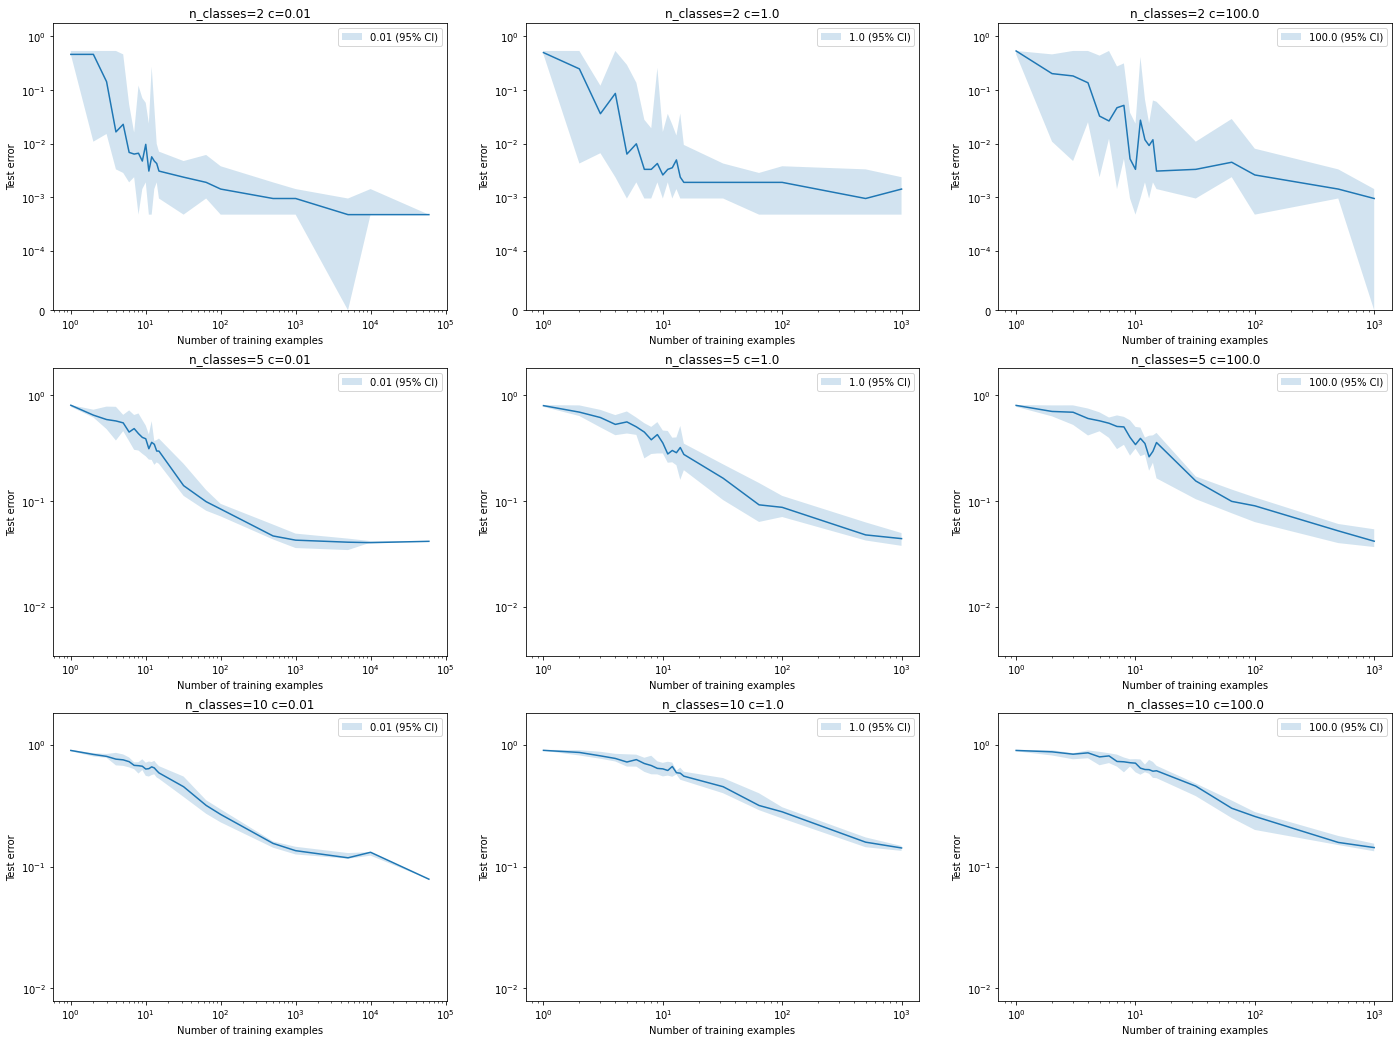

In [9]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

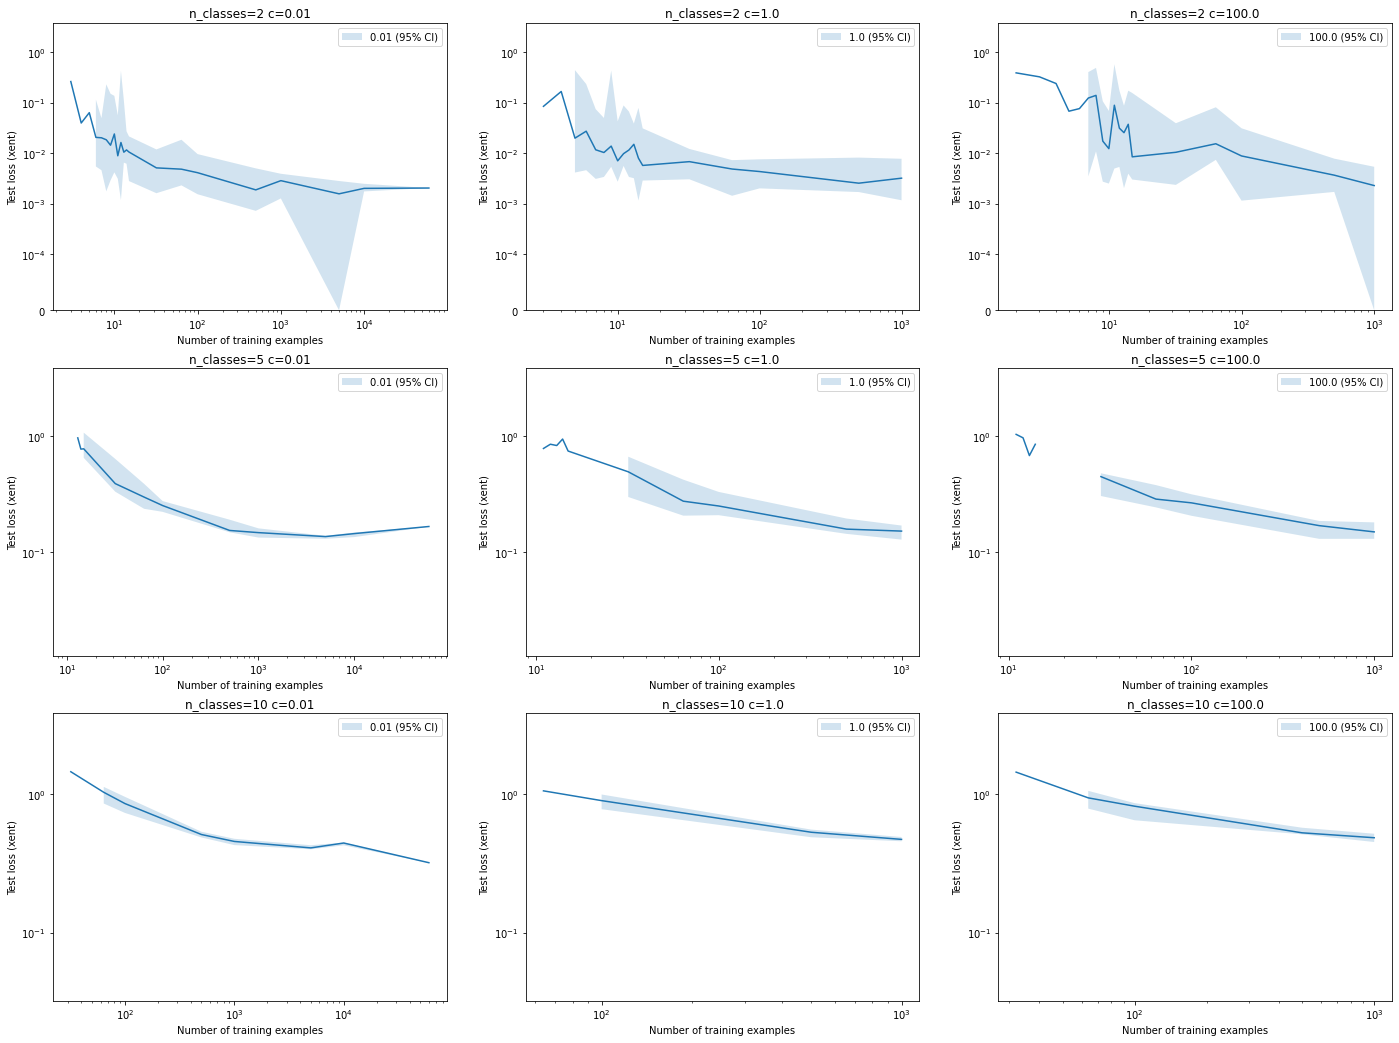

In [10]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")